In [2]:
import pylab as plt
import numpy as np
from scipy.signal import detrend,welch
import scipy.signal as sg
from  lib_filters_obp import *
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.constants as consts

mpl.rcParams.update({'figure.figsize':[10,6],'axes.grid' : True,'font.size': 14,'savefig.facecolor':'white'})

(10000,)
dkx: 0.25132741228718347  mean of window squared: 5.025125628140704e-07 , should be sum of window PSD: 5.025125628140707e-07
Welch sum: mean of window squared: 5.025125628140704e-07 , sum of window PSD: 5.025125628140707e-07
window mean: 0.0001  mean of window squared: 5.025125628140704e-07 , sum of window PSD: 5.025125628140704e-07


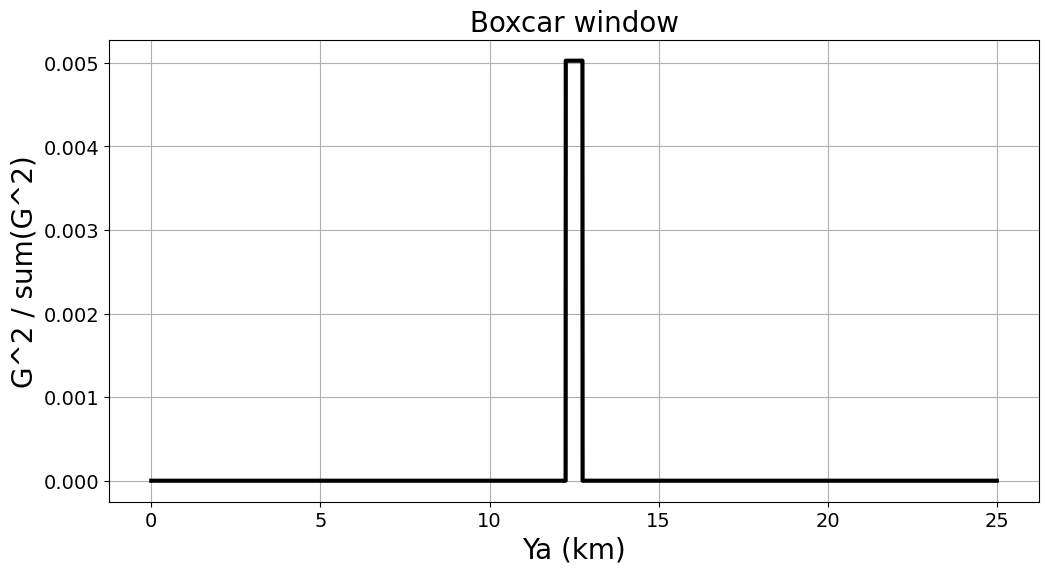

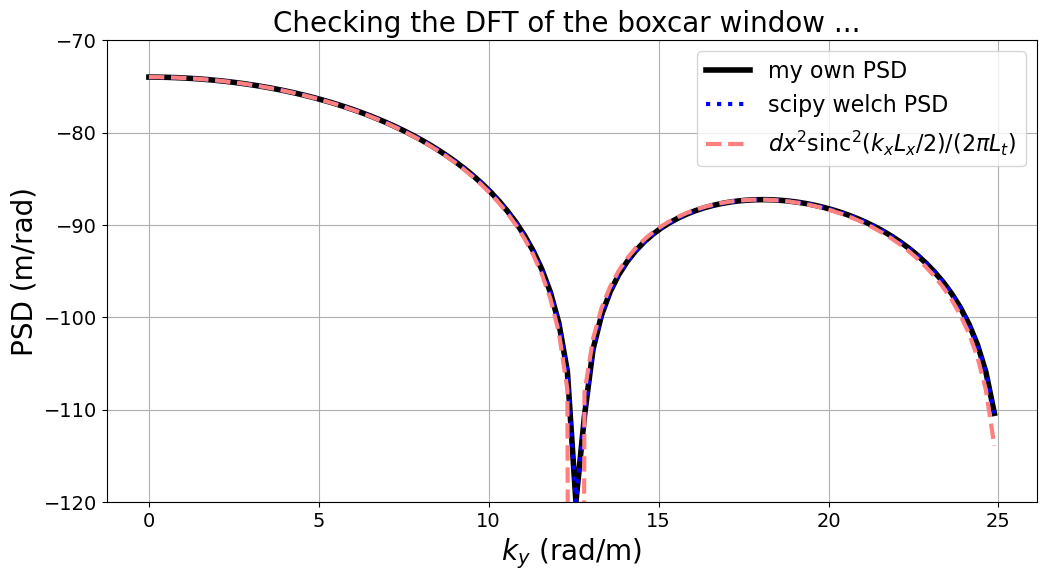

In [3]:
# First we try with a very simple filter: boxcar
# Now we check for the DFT of G^2 in the case of a boxcar shape for G 

nx=10000
dx=0.0025 # in km

Xa = np.arange(0,np.floor(nx*dx),dx)
Xc=Xa[nx//2]
Lx=0.5

Lt=np.max(Xa)-np.min(Xa)  # Lt is the actual length over which the FFT is taken along x

#window= np.exp(-(Xa-Xc)**2/Lx**2)   # This is G ^2  

window=np.zeros(nx)
ind = np.where(abs(Xa-Xc) < Lx/2)[0]
wmax=1./len(ind)
window[ind]=wmax
wm=np.mean(window)
windowWelch=np.ones(nx)


wsum=np.sum(window)
window=window/wsum
wm=np.mean(window)

fig,ax=plt.subplots(figsize=(12,6))
_=ax.set_title(' Boxcar window ', fontsize=20)
_=ax.set_xlabel('Ya (km)', fontsize=20)
_=ax.set_ylabel('G^2 / sum(G^2)' , fontsize=20)
line1=ax.plot(Xa,window,linewidth=3,color='k',label='window')


nfftx=nx

kx, wspec=welch(window, fs=1./dx, nperseg=nfftx, window=windowWelch, detrend=False, return_onesided=False, scaling='density')
print(np.shape(window))

kx=kx*(2*np.pi)
wspec=wspec/(2*np.pi)
dkx=kx[1]-kx[0]

print('dkx:',dkx,' mean of window squared:',np.sum(window**2)/nx, ', should be sum of window PSD:',np.sum(wspec)*dkx)
# The following 3 lines transform the Welch PSD into a spectra along ky 

kLx=kx*Lx 
# WARNING: I'm not using the sinc function from scipy is sin(pi*x)/(pi*x) ... so I use "sinc(kLy/2/np.pi)" instead of sinc(kLy/2)
conv=dx**2/Lt*(np.sinc(kLx/2/np.pi))**2 / (2*np.pi) 
#conv[0]=Ly/ (2*np.pi)/len(ind)**2*(dy*ny/Ly)**-1
print('Welch sum: mean of window squared:',np.sum(window**2)/nx, ', sum of window PSD:',np.sum(wspec)*dkx)



# Checking on Welch ... . 
zspec=(np.abs( np.fft.fft(window)/nfftx  )**2) /dkx 

# Now we check that the normalization is correct
print('window mean:',wm,' mean of window squared:',np.sum(window**2)/nx, ', sum of window PSD:',np.sum(zspec)*dkx)


fig,ax=plt.subplots(figsize=(12,6))
_=ax.set_title('Checking the DFT of the boxcar window ... ', fontsize=20)
_=ax.set_xlabel('$k_y$ (rad/m)', fontsize=20)
_=ax.set_ylabel('PSD (m/rad)' , fontsize=20)
# defines number of wavenumbers for plot 
np1=100
line1=ax.plot(kx[0:np1],10*np.log10(zspec[0:np1]),linewidth=4,color='k',label='my own PSD')
line2=ax.plot(kx[0:np1],10*np.log10(wspec[0:np1]),linewidth=3,color='b',linestyle='dotted',label='scipy welch PSD')
line3=ax.plot(kx[0:np1],10*np.log10(conv[0:np1]),linewidth=3,color=[1,0.5,0.5],linestyle='dashed',label=r'$dx^2 {\mathrm{sinc}}^2 (k_x L_x / 2) /(2\pi L_t)$')
leg = ax.legend(loc='upper right', fontsize=16)

_=ax.set_ylim((-120,-70))
leg = ax.legend(loc='upper right', fontsize=16)
#print('shape:',np.shape(conv),np.shape(ky),ny,'TEST:',np.shape(conv[ny//2:-1]))
#line3=ax.plot(ky,10*np.log10(conv),color='b',label='convolution')

shape: (500,)
shape: (500,) (500,)
dkx: 0.0799999999999983 shape kx: (10000,) (10000,)
 mean of window squared: 0.0206370684032 , should be sum of window PSD: 1.5995471667526836e-07
Welch sum: mean of window squared: 0.0206370684032 , sum of window PSD: 1.5995471667526836e-07
window mean: 0.0001  mean of window squared: 0.0206370684032 , sum of window PSD: 0.01968104210205078
Nb of points OBP kernel: 41


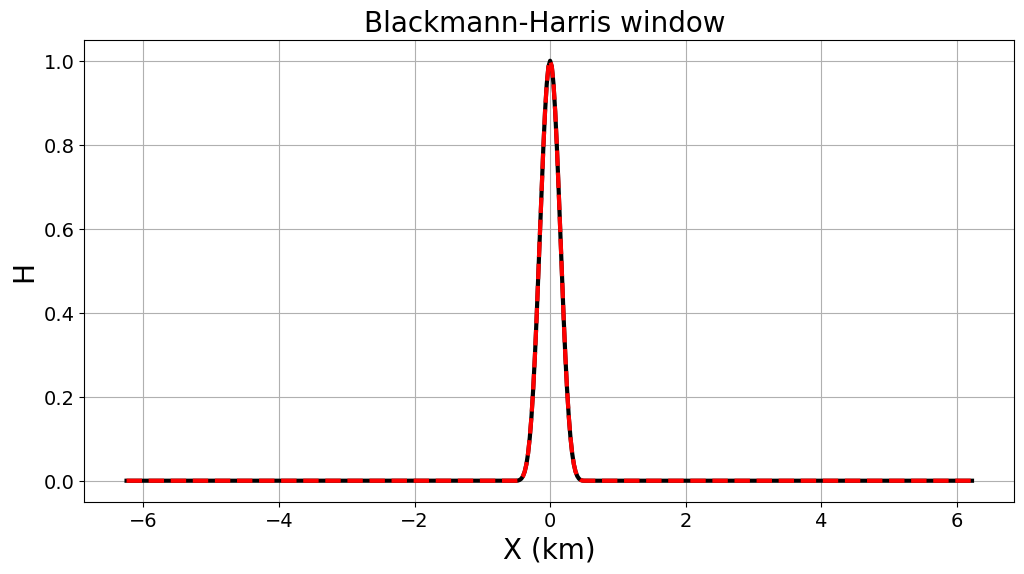

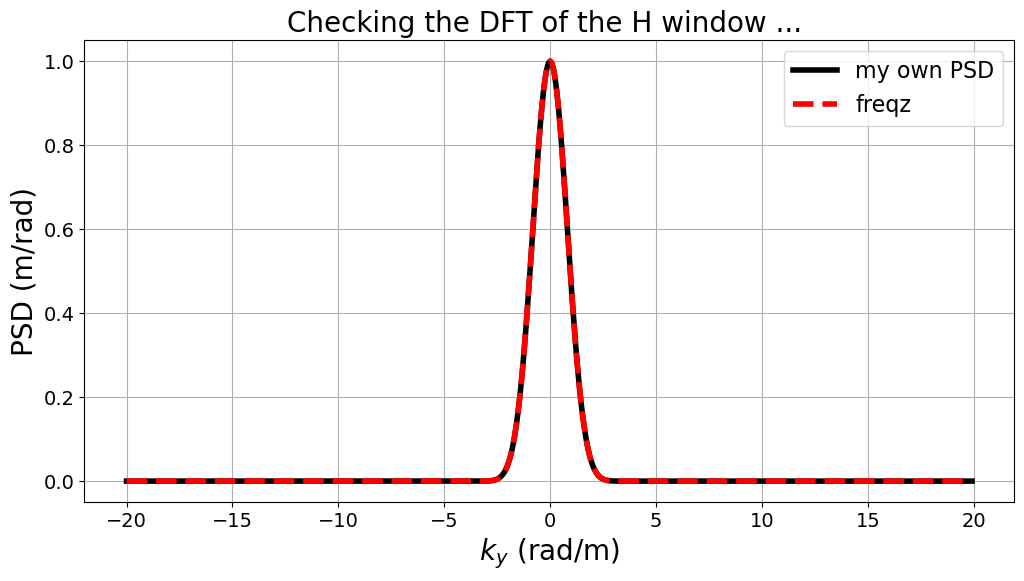

In [4]:
# Now we check for the DFT of G^2 in the case of a boxcar shape for G 

nx=500
dx=0.025 # in km

Xa = np.arange(0,nx*dx,dx)
Xc=Xa[nx//2]
Lx=1
print('shape:',np.shape(Xa))
      
Lt=np.max(Xa)-np.min(Xa)  # Lt is the actual length over which the FFT is taken along x
#
# Defines the Blackmann-Harris window
#https://ccrma.stanford.edu/~jos/sasp/Three_Term_Blackman_Harris_Window.html
a0=0.4243801;a1=0.4973406;a2=0.0782793;a3=0;
a0=0.35875;a1=0.48829;a2=0.14128;a3=0.01168; # this is from scipy code 
xn=(Xa-Xc)*2*np.pi/Lx
ind = np.where(abs(xn) <= np.pi)[0]
window=np.zeros(nx)
winobp=np.zeros(nx)
window[ind]=a0+a1*np.cos(xn[ind])+a2*np.cos(2*xn[ind])+a3*np.cos(3*xn[ind])
winobp[ind]=sg.blackmanharris(len(ind))

windowWelch=np.ones(nx)


print('shape:',np.shape(Xa),np.shape(window))

wsum=np.sum(window)
#window=window/wsum
wsum2=np.sum(winobp)
#winobp=winobp/wsum2


fig,ax=plt.subplots(figsize=(12,6))
_=ax.set_title('Blackmann-Harris window ', fontsize=20)
_=ax.set_xlabel('X (km)', fontsize=20)
_=ax.set_ylabel('H' , fontsize=20)
line1=ax.plot(Xa-Xc,window,linewidth=3,color='k',label='window')
line2=ax.plot(Xa-Xc,winobp,linewidth=3,color='r',ls='dashed',label='scipy')


nfftx=512

#kx, wspec=welch(window, fs=1./dx, nperseg=nfftx, window=windowWelch, detrend=False, return_onesided=False, scaling='density')
#print(np.shape(window),np.shape(k),k[0],k[-1],k[1]-k[0])

kxs= np.fft.fftshift(np.fft.fftfreq(nx, dx)) 
dkx=kxs[1]-kxs[0]

print('dkx:',dkx,'shape kx:',np.shape(kx),np.shape(wspec))

print(' mean of window squared:',np.sum(window**2)/nx, ', should be sum of window PSD:',np.sum(wspec)*dkx)
# The following 3 lines transform the Welch PSD into a spectra along ky 

kLx=kx*Lx 
# WARNING: I'm not using the sinc function from scipy is sin(pi*x)/(pi*x) ... so I use "sinc(kLy/2/np.pi)" instead of sinc(kLy/2)
conv=window
#conv[0]=Ly/ (2*np.pi)/len(ind)**2*(dy*ny/Ly)**-1
print('Welch sum: mean of window squared:',np.sum(window**2)/nx, ', sum of window PSD:',np.sum(wspec)*dkx)



# compute PSD... . 
zspec=np.fft.fftshift((np.abs( np.fft.fft(window)/nfftx  )**2) /dkx )

# Now we check that the normalization is correct
print('window mean:',wm,' mean of window squared:',np.sum(window**2)/nx, ', sum of window PSD:',np.sum(zspec)*dkx)
znorm=zspec/np.nanmax(zspec)

#f_obp, S_obp = sg.freqz(window, fs=4)
x_at, w_at, f_obp, S_obp = get_obp_filter(L_filt = 1, f_axis = kxs, plot_flag = False, kernel="bharris")


fig,ax=plt.subplots(figsize=(12,6))
_=ax.set_title('Checking the DFT of the H window ... ', fontsize=20)
_=ax.set_xlabel('$k_y$ (rad/m)', fontsize=20)
_=ax.set_ylabel('PSD (m/rad)' , fontsize=20)
# defines number of wavenumbers for plot 
np1=100
#line1=ax.plot(kxs,10*np.log10(znorm),linewidth=4,color='k',label='my own PSD')
#line3=ax.plot(kxs,10*np.log10(conv**2),linewidth=3,color=[1,0.5,0.5],linestyle='dashed',label=r'H^2')
#_=ax.set_ylim((-120,0))
line1=ax.plot(kxs,(znorm),linewidth=4,color='k',label='my own PSD')
#line3=ax.plot(kxs,(conv**2),linewidth=3,color=[1,0.5,0.5],linestyle='dashed',label=r'H^2')
#line3=ax.plot(kxs,(conv),linewidth=3,color=[1,0.5,0.5],linestyle='dashed',label=r'H')
line1=ax.plot(f_obp,S_obp,linewidth=4,color='r',label='freqz',linestyle='dashed')
leg = ax.legend(loc='upper right', fontsize=16)

leg = ax.legend(loc='upper right', fontsize=16)
#print('shape:',np.shape(conv),np.shape(ky),ny,'TEST:',np.shape(conv[ny//2:-1]))
#line3=ax.plot(ky,10*np.log10(conv),color='b',label='convolution')



shape: (1000,)
shape: (1000,) (1000,)
dkx: 0.0799999999999983 shape kx: (10000,) (10000,)
 mean of window squared: 0.023101668194007732 , should be sum of window PSD: 1.5995471667526836e-07
Welch sum: mean of window squared: 0.023101668194007732 , sum of window PSD: 1.5995471667526836e-07
window mean: 0.0001  mean of window squared: 0.023101668194007732 , sum of window^2 PSD: 0.05996143244612881
Nb of points OBP kernel: 41
Nb of points OBP kernel: 241


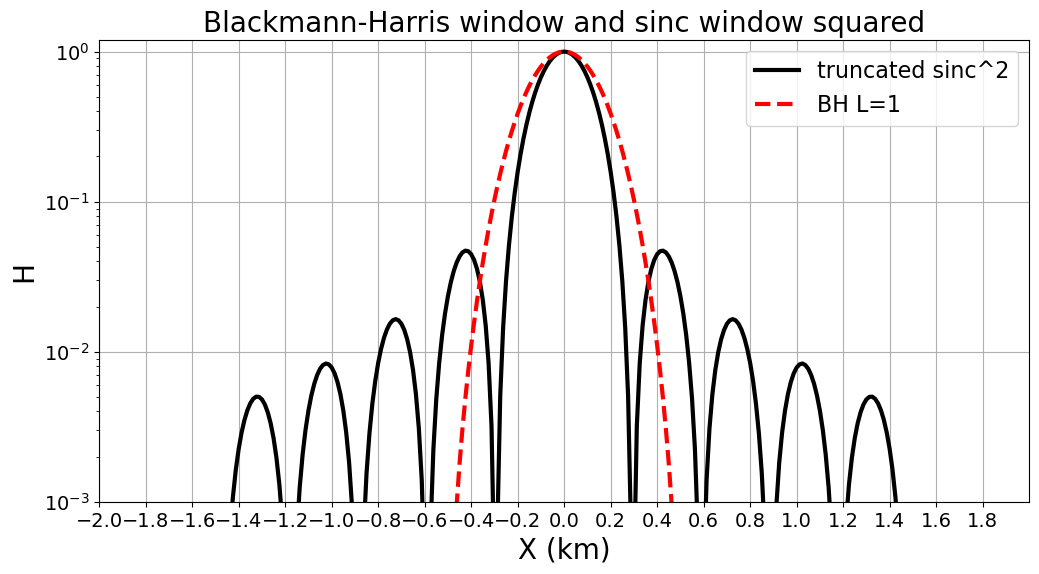

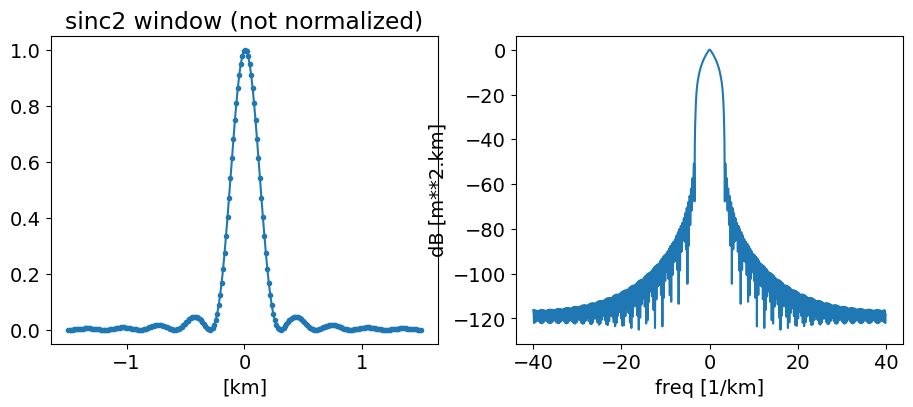

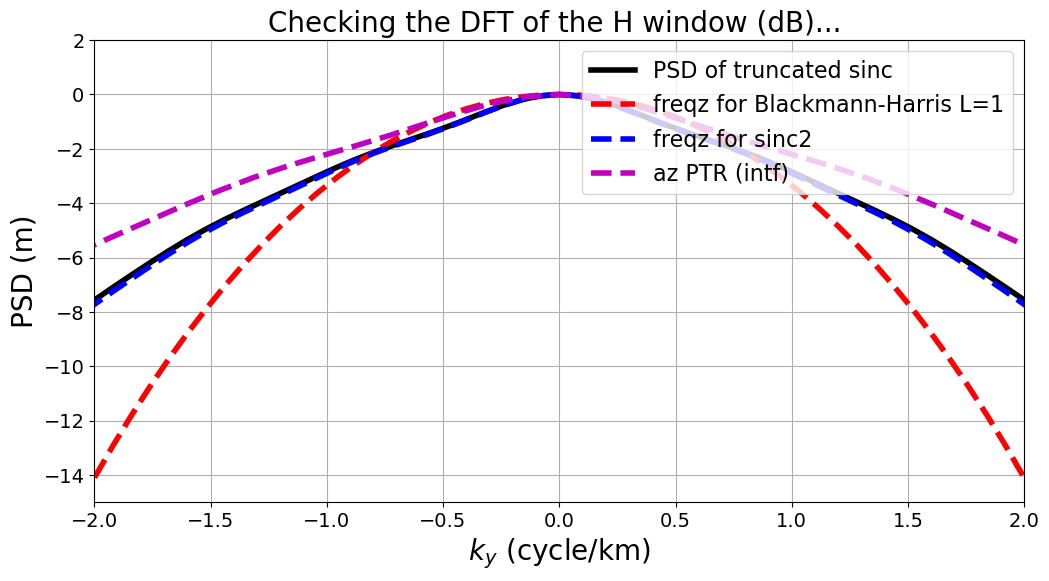

In [5]:
# Now we check for the DFT of G^2 in the case of a Blackmann-Harris and a truncated sinc window

nx=1000
dx=0.0125 # in km

Xa = np.arange(0,nx*dx,dx)
Xc=Xa[nx//2]
Lx=1
print('shape:',np.shape(Xa))
      
Lt=np.max(Xa)-np.min(Xa)  # Lt is the actual length over which the FFT is taken along x
#
# Defines the Blackmann-Harris window
#https://ccrma.stanford.edu/~jos/sasp/Three_Term_Blackman_Harris_Window.html
a0=0.4243801;a1=0.4973406;a2=0.0782793;a3=0;
a0=0.35875;a1=0.48829;a2=0.14128;a3=0.01168; # this is from scipy code 
xn=(Xa-Xc)*2*np.pi/Lx
ind = np.where(abs(xn)*0.54/5 <= 1)[0]
indbh = np.where(abs(xn) <= np.pi)[0]
ind123= np.where(abs(xn/1.1) <= np.pi)[0]
window=np.zeros(nx)
winobp=np.zeros(nx)
winobl=np.zeros(nx)
window[ind]=(np.sinc(xn[ind]*0.54)) 
winobp[indbh]=sg.blackmanharris(len(indbh))
winobl[ind123]=sg.blackmanharris(len(ind123))

windowWelch=np.ones(nx)


print('shape:',np.shape(Xa),np.shape(window))

wsum=np.sum(window)
#window=window/wsum
wsum2=np.sum(winobp)
#winobp=winobp/wsum2


fig,ax=plt.subplots(figsize=(12,6))
_=ax.set_title('Blackmann-Harris window and sinc window squared', fontsize=20)
_=ax.set_xlabel('X (km)', fontsize=20)
_=ax.set_ylabel('H' , fontsize=20)
line1=ax.plot(Xa-Xc,window**2,linewidth=3,color='k',label='truncated sinc^2')
line2=ax.plot(Xa-Xc,winobp,linewidth=3,color='r',ls='dashed',label='BH L=1')
#line2=ax.plot(Xa-Xc,winobl**2,linewidth=3,color='b',ls='dashed',label='BH^2 L=1.23')
ax.set_xlim([-2,2]);
ax.set_ylim([0.001,1.2]);
ax.set_xticks(np.arange(-2,2,0.2))
leg = ax.legend(loc='upper right', fontsize=16)
ax.set_yscale('log')
nfftx=512

#kx, wspec=welch(window, fs=1./dx, nperseg=nfftx, window=windowWelch, detrend=False, return_onesided=False, scaling='density')
#print(np.shape(window),np.shape(k),k[0],k[-1],k[1]-k[0])

kxs= np.fft.fftshift(np.fft.fftfreq(nx, dx)) 
dkx=kxs[1]-kxs[0]

print('dkx:',dkx,'shape kx:',np.shape(kx),np.shape(wspec))

print(' mean of window squared:',np.sum(window**2)/nx, ', should be sum of window PSD:',np.sum(wspec)*dkx)
# The following 3 lines transform the Welch PSD into a spectra along ky 

kLx=kx*Lx 
conv=window
print('Welch sum: mean of window squared:',np.sum(window**2)/nx, ', sum of window PSD:',np.sum(wspec)*dkx)



# compute PSD... . 
zspec=np.fft.fftshift((np.abs( np.fft.fft(window**2)/nfftx  )**2) /dkx )

# Now we check that the normalization is correct
print('window mean:',wm,' mean of window squared:',np.sum(window**2)/nx, ', sum of window^2 PSD:',np.sum(zspec)*dkx)
znorm=zspec/np.nanmax(zspec)

#f_obp, S_obp = sg.freqz(window, fs=4)
x_at, w_at, f_obp, S_obp = get_obp_filter(L_filt = 1, f_axis = kxs, plot_flag = False, kernel="bharris")
#x_at, w_at, f_obp, S_ptr = get_obp_filter(L_filt = 1.23, f_axis = kxs, plot_flag = False, kernel="bharris")
x_at, w_at, f_obp, S_ptr = get_obp_filter(L_filt = 3, sampling_in = 0.0125,f_axis = kxs, plot_flag = True, kernel="sinc2")

# Pieces from Alejandro: 
PRF = 4332
N_burst = 9
v_sat = 7310.
H = 875.0e3
incidence_deg = 3.5 # just used for the ground/range conversion for xtrack

f_s = 300.0e6
v_ground = v_sat/(1+H/6377.0e3)
lambda_c = (consts.c/35.75e9)

d = N_burst*v_ground/PRF # along track posting before OBP averaging


w_ptr = np.zeros(512)
#w_ptr[:71] = np.sinc(2*v_sat*N_burst/(lambda_c*H*PRF)*np.arange(-35,36)*d)**2
w_ptr[:141] = np.sinc(2*v_sat*N_burst/(lambda_c*H*PRF)*np.arange(-70,71)*d)**2
w_ptr /= np.sum(w_ptr)*d







fig,ax=plt.subplots(figsize=(12,6))
_=ax.set_title('Checking the DFT of the H window (dB)... ', fontsize=20)
_=ax.set_xlabel('$k_y$ (cycle/km)', fontsize=20)
_=ax.set_ylabel('PSD (m)' , fontsize=20)

 
# defines number of wavenumbers for plot 
np1=100
#line1=ax.plot(kxs,10*np.log10(znorm),linewidth=4,color='k',label='my own PSD')
#line3=ax.plot(kxs,10*np.log10(conv**2),linewidth=3,color=[1,0.5,0.5],linestyle='dashed',label=r'H^2')
#_=ax.set_ylim((-120,0))
line1=ax.plot(kxs,10*np.log10(znorm),linewidth=4,color='k',label='PSD of truncated sinc')
#line3=ax.plot(kxs,(conv**2),linewidth=3,color=[1,0.5,0.5],linestyle='dashed',label=r'H^2')
#line3=ax.plot(kxs,(conv),linewidth=3,color=[1,0.5,0.5],linestyle='dashed',label=r'H')
line1=ax.plot(f_obp,10*np.log10(S_obp),linewidth=4,color='r',label='freqz for Blackmann-Harris L=1',linestyle='dashed')
line1=ax.plot(f_obp,10*np.log10(S_ptr),linewidth=4,color='b',label='freqz for sinc2',linestyle='dashed')
line_al=ax.plot(1000*np.fft.fftshift(np.fft.fftfreq(len(w_ptr), d=d)),10*np.log10( np.fft.fftshift(np.abs(d*np.fft.fft(w_ptr))**2)),linewidth=4,color='m',linestyle='dashed', label='az PTR (intf)')

leg = ax.legend(loc='upper right', fontsize=16)
ax.set_ylim([-15.0,2]);
ax.set_xlim([-2.0,2.0]);



In [28]:
def G_field_oneway(theta):
    return np.exp(-np.abs(theta/(np.radians(.107)/2))**2.25*np.log(2))


<xarray.Dataset>
Dimensions:       (time: 388, tau: 40)
Coordinates:
  * time          (time) float64 0.000905 0.002941 0.004977 ... 0.7869 0.7889
    transmitter   object ...
    polarization  object ...
  * tau           (tau) float64 0.006045 0.006045 0.006045 ... 0.006045 0.006045
    receiver      object ...
    beam          int64 ...
Data variables:
    PTR_real      (time, tau) float64 ...
    PTR_imag      (time, tau) float64 ...
nr,na 40 388


/home/ardhuin/anaconda3/lib/python3.8/site-packages/xarray/core/computation.py:727: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


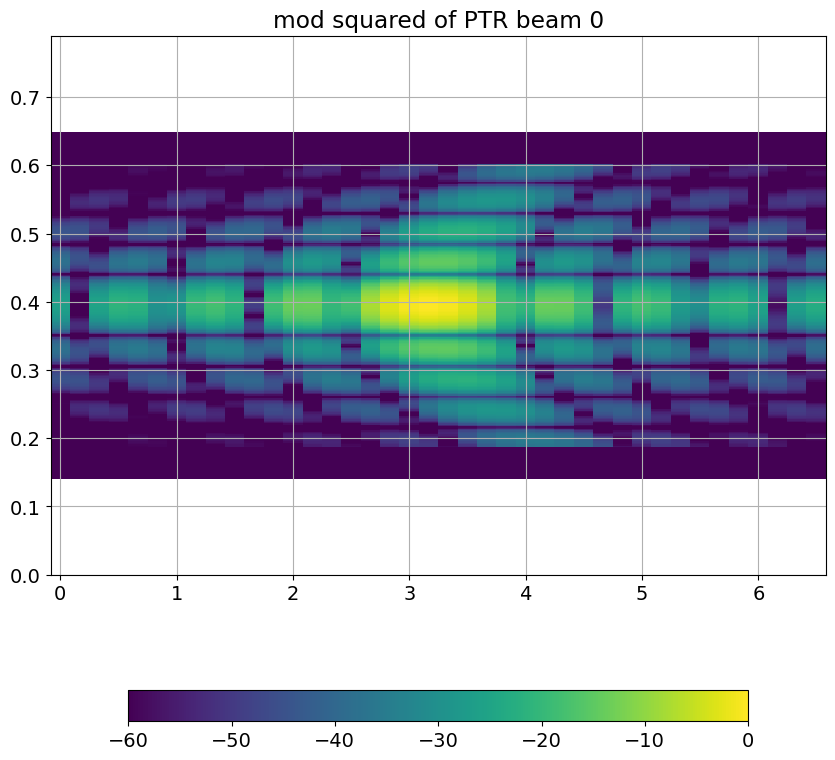

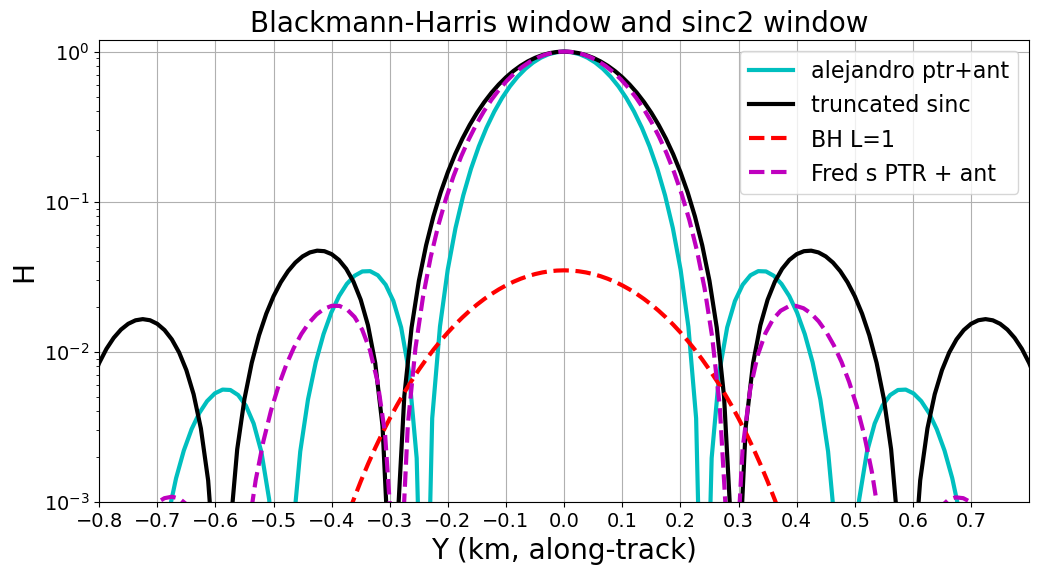

In [36]:
import xarray as xr
ds= xr.open_dataset('SWOT_beam0.nc')
print(ds)
#* tau : (fast time == range). Donc sr = celerity*tau/2 est le slant_range. A projeter ensuite en ground_range en fonction de là où tu es dans la fauchée mais bon, cela ne devrait avoir aucun impact pour toi. (Attention il faut prendre une valeur de la celerité bien précise! j'utilise celle de scipy.constants)
#* time (slow time == azimuth). A convertir en mètres avec la vitesse du satellite que je t'ai mis dans les attributs du netcdf
#Je t'ai laissé en complexe, comme ça tu sauras où mettre les carrés qui vont bien ! Un petit plot en [mètre,mètre] peut être pas mal pour vérifier que le lobe est bien d'environ 300 m en azimuth et autour des 10 m en ground_range en milieu de fauchée (~2 degrés)

ptrmod2=(ds.PTR_real**2+ds.PTR_imag**2)
ptmax=np.max(ptrmod2)
celerity=299792458
sr = celerity*ds.tau/2  # slant range
sr0=np.min(sr)
[na,nr]=np.shape(ptrmod2)
print('nr,na',nr,na)
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10,10))
im=ax.pcolormesh(sr-sr0,ds.time,10*np.log10(ptrmod2/ptmax),cmap='viridis',rasterized=True,vmin=-60, vmax=0)
_=plt.colorbar(im,ax=ax,label='', location='bottom',shrink=0.8)
_=ax.set_title('mod squared of PTR beam 0')
 #plt.setp(axs[1].get_yticklabels(), visible=False)
          
plt.show()

ptrm=ptrmod2[:,nr//2-1]/ptmax
ptrm=np.sum(ptrmod2[:,:],axis=1)
ptmax1=max(ptrm)
ptrm=ptrm/ptmax1


# ALE's stuff 
PRF = 4332
N_burst = 9
v_sat = 7310.
H = 875.0e3
f_s = 300.0e6
v_ground = v_sat/(1+H/6377.0e3)
lambda_c = (consts.c/35.75e9)
incidence_deg = 3.5 # just used for the ground/range conversion for xtrack
d = N_burst*v_ground/PRF # along track posting before OBP averaging
w_ptr = np.zeros(512)
w_ptr[:401] = np.sinc(2*v_sat*N_burst/(lambda_c*H*PRF)*np.arange(-200,201)*d)**2
w_ptr /= np.sum(w_ptr)*d
w_ale = np.zeros(512)
y_tab = np.arange(-200,201)*d+1.0e-3
ant = G_field_oneway(y_tab/H)**4
w_ale[:len(y_tab)] = np.sin(2*np.pi*v_sat*N_burst/(lambda_c*H*PRF)*y_tab)**2/np.sin(2*np.pi*v_sat/(lambda_c*H*PRF)*y_tab)**2*ant
w_ale /= np.max(w_ale)
        
ant_fred=G_field_oneway((ds.time-0.395)*v_ground/H)**4
    
fig,ax=plt.subplots(figsize=(12,6))
_=ax.set_title('Blackmann-Harris window and sinc2 window ', fontsize=20)
_=ax.set_xlabel('Y (km, along-track)', fontsize=20)
_=ax.set_ylabel('H' , fontsize=20)
line1=ax.plot(y_tab*0.001, w_ale[:len(y_tab)],linewidth=3,color='c',label='alejandro ptr+ant')
line1=ax.plot(Xa-Xc,window**2,linewidth=3,color='k',label='truncated sinc')
line2=ax.plot(Xa-Xc,winobp,linewidth=3,color='r',ls='dashed',label='BH L=1')
line2=ax.plot((ds.time-0.395)*v_ground/1000.,ptrm*ant_fred,linewidth=3,color='m',ls='dashed',label='Fred s PTR + ant')

ax.set_yscale('log')
ax.set_xlim([-0.8,0.8]);
ax.set_ylim([0.001,1.2]);
ax.set_xticks(np.arange(-0.8,0.8,0.1))
leg = ax.legend(loc='upper right', fontsize=16)



TEST: 0.013141628959276015 388 0.013073888603815833
Nb of points OBP kernel: 41


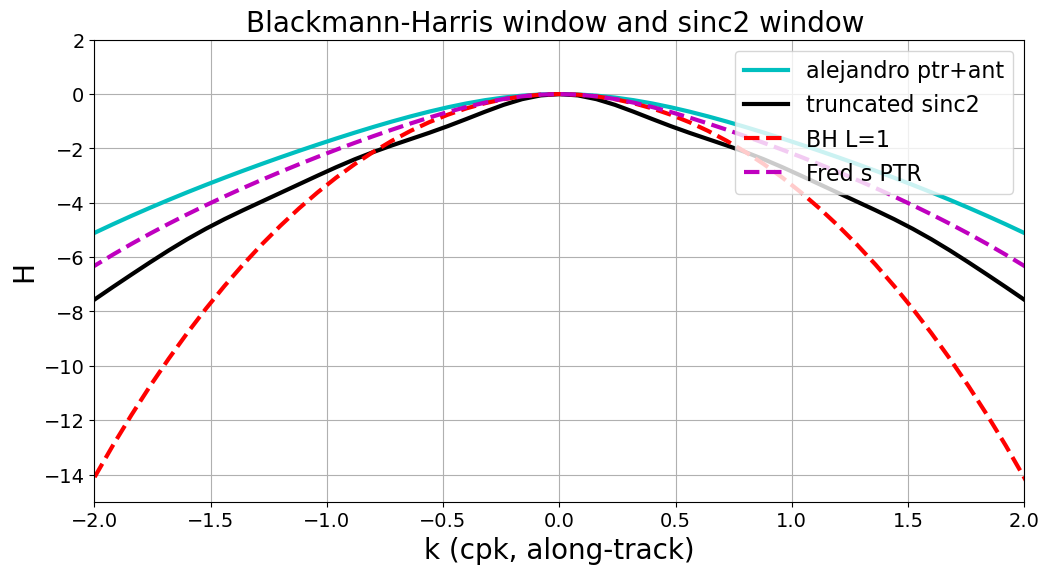

In [35]:
fig,ax=plt.subplots(figsize=(12,6))
_=ax.set_title('Blackmann-Harris window and sinc2 window ', fontsize=20)
_=ax.set_xlabel('k (cpk, along-track)', fontsize=20)
_=ax.set_ylabel('H' , fontsize=20)

time=ds.time.values
dxfred=(time[1]-time[0])*6.454
print('TEST:',(time[1]-time[0])*6.454,len(time),(time[-1]-time[1])*6.454/len(time))

x_at, w_at, f_obp, H_ptr = get_obp_filter(L_filt = 1,f_axis = kxs, plot_flag = False, kernel="alejandro_azptr")
line1=ax.plot(f_obp, 10*np.log10(H_ptr),linewidth=3,color='c',label='alejandro ptr+ant')
w_obp=window**2
w_obp /= np.sum(w_obp)
f_obp, S_obp = sg.freqz(w_obp, fs=1/(Xa[1]-Xa[0]), worN=kxs)
S_obp = np.abs(S_obp)**2
line1=ax.plot(f_obp, 10*np.log10(S_obp),linewidth=3,color='k',label='truncated sinc2')
w_obp=winobp
w_obp /= np.sum(w_obp)
f_obp, S_obp = sg.freqz(w_obp, fs=1/(Xa[1]-Xa[0]), worN=kxs)
S_obp = np.abs(S_obp)**2
line2=ax.plot(f_obp, 10*np.log10(S_obp),linewidth=3,color='r',ls='dashed',label='BH L=1')

w_obp=ptrm
w_obp /= np.sum(w_obp)
f_obp, S_obp = sg.freqz(w_obp, fs=1/(Xa[1]-Xa[0]), worN=kxs)
S_obp = np.abs(S_obp)**2
line2=ax.plot(f_obp, 10*np.log10(S_obp),linewidth=3,color='m',ls='dashed',label='Fred s PTR')


ax.set_ylim([-15.0,2]);
ax.set_xlim([-2.0,2.0]);
leg = ax.legend(loc='upper right', fontsize=16)
